# *K-means* e *bisecting K-means* 

O objetivo deste projeto é realizar uma análise qualitative entre o K-means e o bisecting K-means. As bases de dados utilizadas serão a [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) e o [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine).

O pré-processamento e o estudo da redução de dimensionalidade foram executados no arquivo [Normalização_e_seleção_de_features](Normalização_e_seleção_de_features.ipynb)


In [1]:
from sklearn import metrics
from time    import time
from math    import sqrt,sin
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import random            as rd
    
# Metricas utilizadas
silhouete = metrics.silhouette_score
v_measure = metrics.v_measure_score
adj_rd    = metrics.adjusted_rand_score

# Argumentos e pré-definições do seaborn
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style="ticks")

filepath_iris = '../data/Iris-norm.csv'
filepath_wine = '../data/Wine-norm.csv'

iris_df = pd.read_csv(filepath_iris)
wine_df = pd.read_csv(filepath_wine)

### Funções auxiliares para plotagem

In [2]:
def plotter(doc, ks, label):
    X,Y,L = zip(*doc)

    kx,ky = zip(*ks)
    plt.scatter(x=X,y=Y, marker='o', c=label, cmap='gist_rainbow')
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)
    
def plotter2(doc):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o', cmap='gist_rainbow')
    
def plotter3(doc, label, ks=None):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o', c=label, cmap='gist_rainbow')
    if ks is not None:
        kx,ky = zip(*ks)
        plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)

def plotter4(doc, label):
    X,Y = zip(*doc)
    maping = {key:count for count,key in enumerate(label)}
    label2 = [maping[i] for i in label]
    
    plt.scatter(x=X,y=Y, marker='o', c=label2, cmap='gist_rainbow')

## *K-Means*

In [3]:
def euclidianDistance(p1, p2):
    return sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

In [4]:
def SSE(centroids, data):
    sum_sq_err = 0
    for centroid in centroids:
        for p in data:
            sum_sq_err += (euclidianDistance(centroid, p) ** 2)
            
    return sum_sq_err

In [5]:
MAX_ITER = 150
def breakCondition(old_centroids, curr_centroids,itter, data, min_gain):
    if itter >= MAX_ITER: return True
    
    old_sse = SSE(old_centroids, data)
    cur_sse = SSE(curr_centroids, data)
    
    if abs(old_sse - cur_sse) < min_gain:
        return True
    
    return False

In [6]:
def defineNewCentroids(S, old_centroids, dist_func):
    color = {cen:i for i,cen in enumerate(old_centroids)}
    centroids = dict()
    labels = []
    groups = {}
    
    for p in S:
        distances = [(dist_func(p, centroid), centroid) for centroid in old_centroids]
        closest_centroid = min(distances, key=lambda x: x[0])[1]
        
        label = color[closest_centroid]
        labels.append(label)
        
        
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1, "points":[p]}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
            centroids[label]["points"].append(p)
 
    new_centroids = [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]

    return new_centroids,labels,[centroids[c]['points'] for c in centroids]

In [7]:
def getRandomCentroids(S, k, existing=False):
    if existing:
        return [tuple(s) for s in rd.sample(S, k)]
    else:
        maxxy = [max(S, key=lambda x: x[0])[0], max(S, key=lambda x: x[1])[1]]
        return [(rd.random()*maxxy[0], rd.random()*maxxy[1]) for _ in range(k)]

In [8]:
def kmeans(S, k, dist_func=euclidianDistance, min_gain=0.00001):
    curr_centroids = getRandomCentroids(S, k, existing=True)
    old_centroids  = getRandomCentroids(S, k, existing=False)
    itter = 0
    predicted = []
    groups = []
    
    while True:
        old_centroids = curr_centroids       
        curr_centroids,predicted,groups = defineNewCentroids(S, old_centroids, dist_func)
        itter += 1
        if breakCondition(old_centroids, curr_centroids, itter, S, min_gain):
            break
        
    return predicted,old_centroids,groups

### Funções de auxiliares para avaliar o *K-Means* 
<a id='algo'></a>
[melhor k](#melhork)

In [45]:
def find_best_k_value(document, atribute, plot_name, metric=adj_rd, min_gain=0.1):
    maping = {key:count for count,key in enumerate(atribute)}
    Y = [maping[i] for i in atribute]

    best_accuracy = -2
    best_centr = []
    best_k = -1
    best_label = []
    inicio = time()
    accuracy = 0

    for _ in range(15):
        for K in range(2, 10):
            y_pred, centroids, _ = kmeans(document, K, min_gain=min_gain)
            accuracy = metric(Y, y_pred)
            if accuracy >= best_accuracy:
                best_accuracy = accuracy
                best_centr = centroids
                best_k = K
                best_label = y_pred

    final = time()

    print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} ({metric.__name__})\nTempo: {final-inicio}")
    plotter3(document, best_label, ks=best_centr)
    plt.savefig(plot_name)

In [10]:
def k_by_acc(X, label, plot_name, metric=adj_rd):
    maping = {key:count for count,key in enumerate(label)}
    Y = [maping[i] for i in label]
    k_acc = []
    acc,y_pred = 0,0

    inicio = time()

    for K in range(1, 40):
        y_pred, _,_ = kmeans(X, K, euclidianDistance)
        acc = metric(Y, y_pred)
        k_acc.append([K, acc])


    final = time()
    max_point = max(k_acc, key=lambda x: x[1])
    
    print(f"Time: {final-inicio}\nMelhor K: {max_point[0]}\nTendo uma acurácia de: {max_point[1]}\n\nGráfico: K por Acurácia ({metric.__name__})")

    plotter2(k_acc)
    plt.savefig(plot_name)

## *Bisecting K-Means*

No desenvolvimento deste algoritmo nos inspiramos no código do munikarmanish, que pode ser encontrado na [sua página](https://github.com/munikarmanish/kmeans/blob/master/test_bisecting.py) do GitHub

In [11]:
"""Return cordinate of a centroid"""
def getCentroid(data):
    return np.mean(data, 0)


"""Calculate the SSE of the given data."""
def sse(data):
    u = getCentroid(data)
    return np.sum(np.linalg.norm(data - u, 2, 1))

In [12]:
def BKM(data, distance_function=euclidianDistance, min_profit=0.01, MAX_K=8):
    
    C = [data]
    K = 1
    gain = 0.001
    current_data = []
    
    while True:
        sse_for_all_clusters = np.array([sse(cluster) for cluster in C])
        old_sse = np.sum(sse_for_all_clusters)
        
        current_data = C.pop(np.argmax(sse_for_all_clusters))
        K += 1
        
        y_pred, centroids, groups = kmeans(current_data, 2, distance_function)
        
        C.append(groups[0])
        C.append(groups[1])
        
        sse_for_all_clusters = np.array([sse(cluster) for cluster in C])
        new_sse = np.sum(sse_for_all_clusters)
        
        gain = (old_sse - new_sse)
        
        if K >= MAX_K or gain < min_profit:
            break
            
    final_centroids = [getCentroid(np.array(group)).tolist() for group in C]
    
    X, labels = [], []
    for i,group in enumerate(C):
        X.extend(group)
        labels.extend([i] * len(group))
    
    return labels,final_centroids,C
        

In [13]:
def bkm_analizer(X, label_true, plot_name, maxk=1000, minprofit=100, metric=v_measure):
    maping = {key:count for count,key in enumerate(label_true)}
    Y = [maping[i] for i in label_true]
    
    best_accuracy = -2
    best_centr = []
    best_k = -1
    best_label = []
    best_time = -1
    best_X = []
    
    for K in range(1, 20):
        ini = time()
        labels,centroids,groups = BKM(X, MAX_K=maxk, min_profit=minprofit)
        fin = time()

        tempo = fin-ini

        X = []
        for group in groups:
            X.extend(group)

        if metric.__name__ == 'silhouette_score':
            acc = metric(X, labels)
        else:
            acc = metric(Y, labels)
        
        if acc >= best_accuracy:
            best_X = X
            best_accuracy = acc
            best_centr = centroids
            best_k = len(centroids)
            best_label = labels
            best_time = tempo

    print(f"Melhor qtd Centróides: {best_k}\n\nAcurácia: {best_accuracy}\n\nTempo: {best_time}\nutilizando: {metric.__name__}\n")

    plotter3(best_X,best_label, ks=best_centr)
    
    plt.savefig(plot_name)

# Medidas de Acurácia

## K-Fold

In [14]:
def kfold_test(X, label, plot_name, k=2, means='classic', minimal_profit=100, metric=adj_rd):
    accuracies = []
    tempos = []
    document = X
    y_true = label

    for N in range(1, 2):
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        for train_index, test_index in kfold.split(document, y_true):
            document_train = []
            y_train_true = []
            for i in train_index:
                document_train.append(document[i])
                y_train_true.append(y_true[i])
                
            if means == 'classic':
                pred_train_KM, cent_train_KM, _ = kmeans(document_train, k)
            elif means == 'bisect':
                pred_train_KM, cent_train_KM, _ = BKM(document_train, MAX_K=100, min_profit=minimal_profit)

            accuracy_train = metric(y_train_true, pred_train_KM)

            document_test = []
            y_test_true = []
            for i in test_index:
                document_test.append(document[i])
                y_test_true.append(y_true[i])
            
            ini_test = time()
            if means == 'classic':
                pred_test_KM, cent_test_KM, _ = kmeans(document_test, k)
            elif means == 'bisect':
                pred_test_KM, cent_test_KM, _ = BKM(document_test, MAX_K=100, min_profit=minimal_profit)
            
            fin_test = time()

            accuracy_test = metric(y_test_true, pred_test_KM)
            accuracies.append(accuracy_test)
            tempo = fin_test - ini_test
            tempos.append(tempo)
    
    media_acc = np.mean(np.array(accuracies))
    media_tempo = np.mean(np.array(tempos))
    print(f"Qtd centroides: {len(cent_test_KM)}\n\nMédia das acurácias: {media_acc}\n\nMédia dos tempos: {media_tempo}")
    plotter3(document_test, pred_test_KM, ks=cent_test_KM)
    plt.savefig(plot_name)

## Basic Cross Validation

In [15]:
def test_split(X, label, plot_name, k=2, means='classic', minimal_profit=100, metric=adj_rd):
    y_true = label
    accuracies = []
    
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.4, random_state=42)
#         print(f"{len(X_train)}, {len(X_test)}, {len(y_train)}, {len(y_test)}")
        
        if means == 'classic':
                pred_train, cent_train, _ = kmeans(X_train, k)
        elif means == 'bisect':
                pred_train, cent_train, _ = BKM(X_train, MAX_K=100, min_profit=minimal_profit)
        accuracy_train = metrics.v_measure_score(y_train, pred_train)
        
        if means == 'classic':
                pred_test, cents_test, _ = kmeans(X_test, k)
        elif means == 'bisect':
                pred_test, cents_test, _ = BKM(X_test, MAX_K=100, min_profit=minimal_profit)
                
        accuracy_test = metric(y_test, pred_test)
        accuracies.append(accuracy_test)
        
    media = np.mean(np.array(accuracies))
    print(f"Qtd centroides: {len(cents_test)}\n\nMédia das acurácias: {media}")
    plotter3(X_test, pred_test, ks=cents_test)
    plt.savefig(plot_name)

## Iris *database*

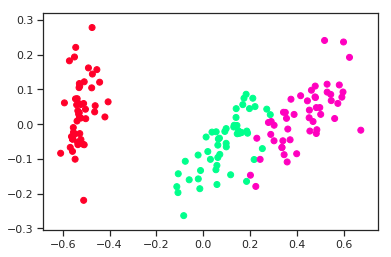

In [16]:
iris_document = list(zip(iris_df.PCA1, iris_df.PCA2))
iris_label = list(iris_df.species)

plotter4(iris_document, iris_label)
plt.savefig("Iris_database.pdf")

### Melhor k no *k-means*
<a id='melhork'></a>
[algo](#algo)

Melhor valor para o K:   3
Obtendo uma acurácia de: 0.8856970310281228 (adjusted_rand_score)
Tempo: 2.3359310626983643


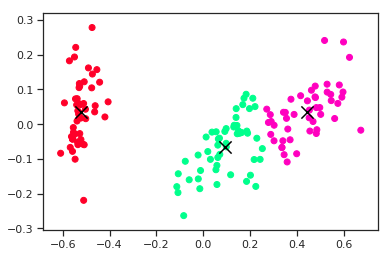

In [17]:
find_best_k_value(iris_document, iris_df.species, "Iris_best_k.pdf")

### K por Acurácia

Time: 1.813081979751587
Melhor K: 3
Tendo uma acurácia de: 0.8856970310281228

Gráfico: K por Acurácia (adjusted_rand_score)


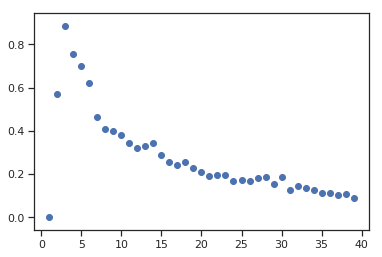

In [18]:
k_by_acc(iris_document, iris_label, "Iris_k_by_acc.pdf")

### Analise BKM

Melhor qtd Centróides: 3

Acurácia: 0.9602776916338867

Tempo: 0.012816667556762695
utilizando: adjusted_rand_score



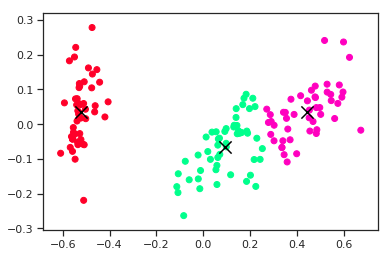

In [19]:
bkm_analizer(iris_document, iris_label, "Iris_best_BKM.pdf", maxk=1000, minprofit=10, metric=adj_rd)

### *K-means vs Bisecting k-means*

#### *K-Means*

Qtd centroides: 3

Média das acurácias: 0.7672182420683908

Média dos tempos: 0.0005592107772827148


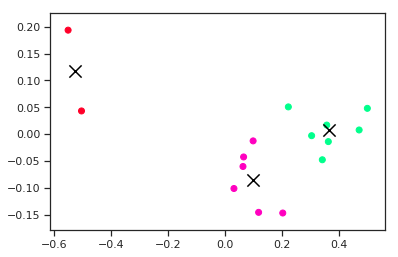

In [20]:
kfold_test(iris_document, iris_label, "Iris_kfold_normal.pdf", k=3, means='classic')

#### *Bisecting K-Means*

Qtd centroides: 2

Média das acurácias: 0.5509424729090109

Média dos tempos: 0.0008689403533935547


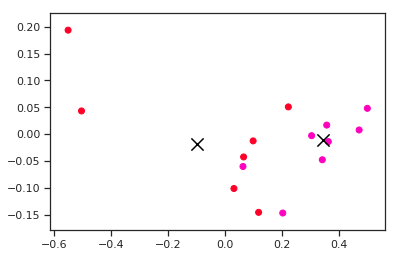

In [21]:
kfold_test(iris_document, iris_label, "Iris_kfold_BKM.pdf", means='bisect', minimal_profit=10)

## Wine *database*

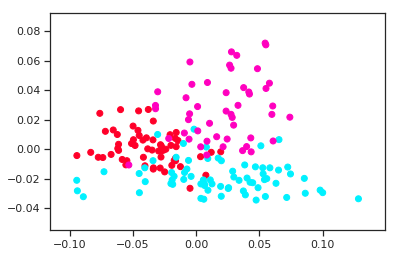

In [22]:
wine_document = list(zip(wine_df.PCA1, wine_df.PCA2))
wine_label = list(wine_df.Class)

plotter4(wine_document, wine_label)
plt.savefig("Wine_database.pdf")

### Melhor k no *k-means*

Melhor valor para o K:   3
Obtendo uma acurácia de: 0.4051601187814473 (adjusted_rand_score)
Tempo: 3.398455858230591


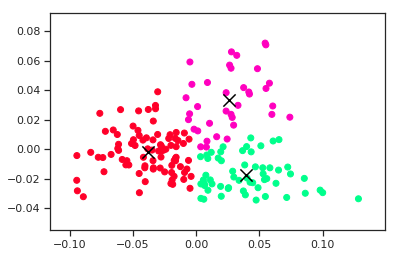

In [23]:
find_best_k_value(wine_document, wine_df.Class, "Wine_best_k.pdf")

### K por Acurácia

Time: 2.692704916000366
Melhor K: 3
Tendo uma acurácia de: 0.4051601187814473

Gráfico: K por Acurácia (adjusted_rand_score)


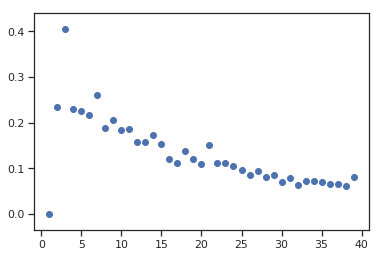

In [24]:
k_by_acc(wine_document, wine_label, "Wine_k_by_acc.pdf")

### Analise BKM

Melhor qtd Centróides: 3

Acurácia: 0.540588081611562

Tempo: 0.010708808898925781
utilizando: adjusted_rand_score



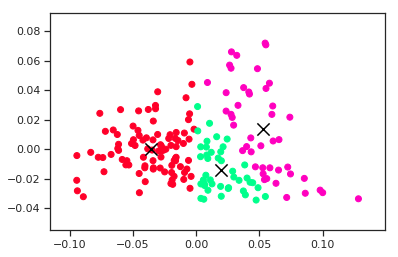

In [25]:
bkm_analizer(wine_document, wine_label, "Wine_best_BKM.pdf", maxk=1000, minprofit=2, metric=adj_rd)

### *K-means vs BKM*

#### *K-means*

Qtd centroides: 3

Média das acurácias: 0.2687832802271049

Média dos tempos: 0.000888657569885254


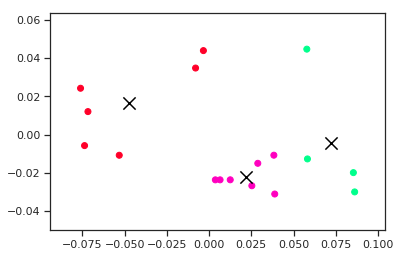

In [26]:
kfold_test(wine_document, wine_label, "Wine_kfold_normal.pdf", k=3, means='classic')

#### *BKM*

Qtd centroides: 3

Média das acurácias: 0.40478024179893995

Média dos tempos: 0.0011510133743286132


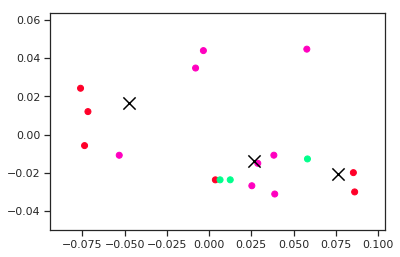

In [27]:
kfold_test(wine_document, wine_label, "Wine_kfold_BKM.pdf", means='bisect', minimal_profit=0.2)

# *DataSets* sintéticos

## Tipo concha

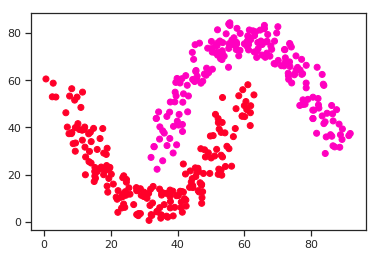

In [28]:
fx1 = lambda x: 4*x   +(1.2*rd.random()) *8
fx2 = lambda x: 4*x   +29+(1.2*rd.random()) *8

fy1 = lambda y: ((y-7) **2) + 15*rd.random()
fy2 = lambda y: ((-(((y-7)) **2))) + 70 + 15*rd.random()
conchas_label = []

alcance = np.arange(0, 14.0, 0.07)

conchas  = [(fx1(i),fy1(i)) for i in alcance]
conchas_label += [1]*len(alcance)

conchas += [(fx2(i),fy2(i)) for i in alcance]
conchas_label += [2]*len(alcance)

plotter3(conchas, conchas_label)

### Melhor k no *k-means*

Melhor valor para o K:   2
Obtendo uma acurácia de: 0.5765386934673367 (adjusted_rand_score)
Tempo: 25.206608772277832


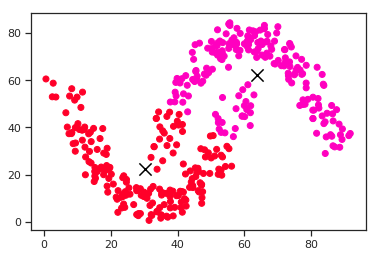

In [53]:
find_best_k_value(conchas,conchas_label, "conchas_best_k.pdf", metric=adj_rd, min_gain=0.1)

### K por Acurácia

Time: 21.78101372718811
Melhor K: 2
Tendo uma acurácia de: 0.5765386934673367

Gráfico: K por Acurácia (adjusted_rand_score)


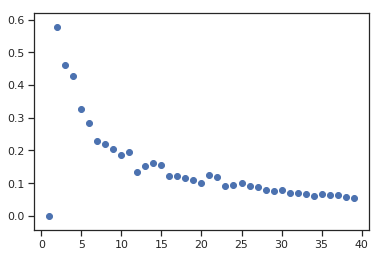

In [30]:
k_by_acc(conchas, conchas_label, "conchas_k_by_acc.pdf")

### Analise BKM

Melhor qtd Centróides: 13

Acurácia: 0.41739270857614424

Tempo: 0.13504576683044434
utilizando: v_measure_score



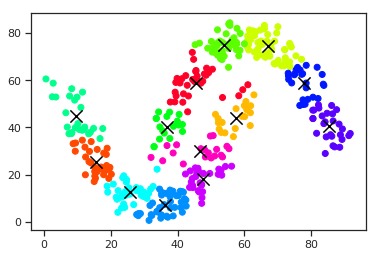

In [31]:
bkm_analizer(conchas, conchas_label, "conchas_best_BKM.pdf", maxk=1000, minprofit=100, metric=v_measure)

### *K-means vs BKM*

#### *K-means*

Qtd centroides: 2

Média das acurácias: 0.5584162746065123

Média dos tempos: 0.002201533317565918


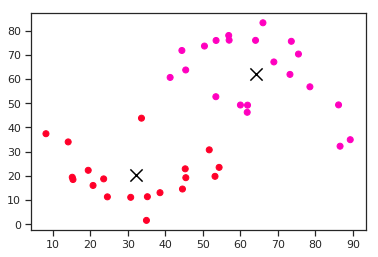

In [32]:
kfold_test(conchas, conchas_label, "conchas_kfold_normal.pdf", k=2, means='classic')

#### *BKM*

Qtd centroides: 2

Média das acurácias: 0.7709472372012044

Média dos tempos: 0.003447079658508301


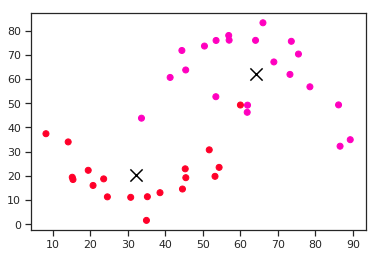

In [33]:
kfold_test(conchas, conchas_label, "conchas_kfold_BKM.pdf", means='bisect', minimal_profit=600)

## Tipo bloco

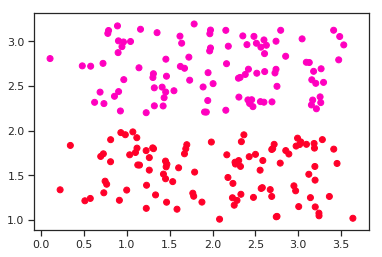

In [34]:
alcance2 = np.arange(0, 3, 0.03)

blocos_label = [] 
blocos =  [(i+rd.random(), 1+rd.random()) for i in alcance2]
blocos_label += [1]*len(alcance2)

blocos += [(i+rd.random(), 2.2+rd.random()) for i in alcance2]
blocos_label += [2]*len(alcance2)

plotter3(blocos, blocos_label)
plt.savefig('blocks.pdf')

### Melhor k no *k-means*

Melhor valor para o K:   4
Obtendo uma acurácia de: 0.6695791061882175 (v_measure_score)
Tempo: 6.735663175582886


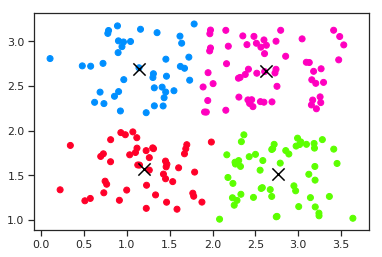

In [35]:
find_best_k_value(blocos, blocos_label, "blocos_best_k.pdf", metric=v_measure)

### K por Acurácia

Time: 5.551631212234497
Melhor K: 4
Tendo uma acurácia de: 0.49791976474126554

Gráfico: K por Acurácia (adjusted_rand_score)


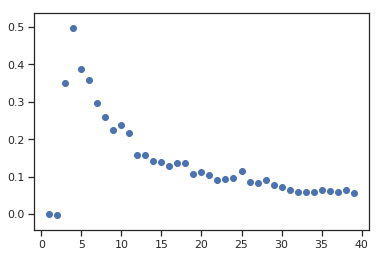

In [36]:
k_by_acc(blocos, blocos_label, "blocos_k_by_acc.pdf")

### Analise BKM

Melhor qtd Centróides: 2

Acurácia: 0.9291252238549084

Tempo: 0.00965118408203125
utilizando: v_measure_score



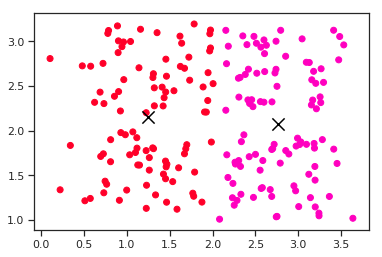

In [37]:
bkm_analizer(blocos, blocos_label, "blocos_best_BKM.pdf", maxk=1000, minprofit=100, metric=v_measure)

### *K-means vs BKM*

#### *K-means*

Qtd centroides: 2

Média das acurácias: 0.1649410233621304

Média dos tempos: 0.0010365724563598632


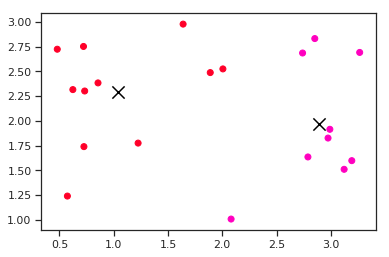

In [38]:
kfold_test(blocos, blocos_label, "blocos_kfold_normal.pdf", k=2, means='classic', metric=v_measure)

#### *BKM*

Qtd centroides: 2

Média das acurácias: 0.6749170133756828

Média dos tempos: 0.0011863231658935547


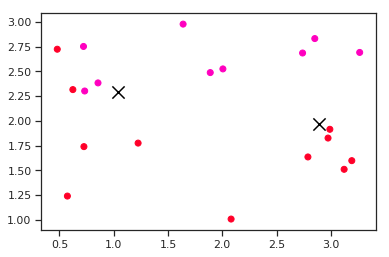

In [39]:
kfold_test(blocos, blocos_label, "blocos_kfold_BKM.pdf", means='bisect', minimal_profit=42, metric=v_measure)